# Realistic run of Treebank NER corpus
1. New evaluation, based on mention sets (in `11_eval_new.ipynb`)
1. Run YAP on test set - realistic_test_set
1. Use original Train-Dev-Test splits
1. Evaluate using new evaluation

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [5]:
from conlleval import evaluate

In [6]:
from ner_utils import *

Using TensorFlow backend.


## Run YAP on test set - realistic_test_set

In [7]:
def make_conll_df(path):
    # CoNLL file is tab delimeted with no quoting
    # quoting=3 is csv.QUOTE_NONE
    df = (pd.read_csv(path, sep='\t', header=None, quoting=3, 
                names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC'])
                # add sentence labels
                .assign(sent = lambda x: (x.ID==1).cumsum())
                # replace bad root dependency tags
                .replace({'DEPREL': {'prd': 'ROOT'}})
               )
    
    df = df.merge(df[['ID', 'FORM', 'sent', 'UPOS']].rename(index=str, columns={'FORM': 'head_form', 'UPOS': 'head_upos'}).set_index(['sent', 'ID']),
               left_on=['sent', 'HEAD'], right_index=True, how='left')
    return df

In [9]:
dev_df = make_conll_df('hebtb_spmrl/yap_output/dev_hebtb_dep.conll')
dev_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos
0,1,עשרות,עשר,CDT,CDT,gen=F|num=P,2,num,_,_,1,אנשים,NN
1,2,אנשים,איש,NN,NN,gen=M|num=P,3,subj,_,_,1,מגיעים,BN
2,3,מגיעים,הגיע,BN,BN,gen=M|num=P|per=A,14,conj,_,_,1,אך,CC
3,4,מ,מ,PREPOSITION,PREPOSITION,NaN,3,comp,_,_,1,מגיעים,BN
4,5,תאילנד,תאילנד,NNP,NNP,gen=F|num=S,4,pobj,_,_,1,מ,PREPOSITION


In [10]:
test_df = make_conll_df('hebtb_spmrl/yap_output/test_hebtb_dep.conll')
test_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos
0,1,אחרים,אחר,JJ,JJ,gen=M|num=P,8,subj,_,_,1,מאמינים,BN
1,2,ב,ב,PREPOSITION,PREPOSITION,NaN,1,prepmod,_,_,1,אחרים,JJ
2,3,ה,ה,DEF,DEF,NaN,4,def,_,_,1,תנועה,NN
3,4,תנועה,תנועה,NN,NN,gen=F|num=S,2,pobj,_,_,1,ב,PREPOSITION
4,5,ה,ה,DEF,DEF,NaN,6,def,_,_,1,קיבוצית,JJ


In [11]:
dev_df['new_pos'] = dev_df.UPOS.map(yap_to_ud)
dev_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos,new_pos
0,1,עשרות,עשר,CDT,CDT,gen=F|num=P,2,num,_,_,1,אנשים,NN,NUM
1,2,אנשים,איש,NN,NN,gen=M|num=P,3,subj,_,_,1,מגיעים,BN,NOUN
2,3,מגיעים,הגיע,BN,BN,gen=M|num=P|per=A,14,conj,_,_,1,אך,CC,VERB
3,4,מ,מ,PREPOSITION,PREPOSITION,NaN,3,comp,_,_,1,מגיעים,BN,ADP
4,5,תאילנד,תאילנד,NNP,NNP,gen=F|num=S,4,pobj,_,_,1,מ,PREPOSITION,PROPN


In [12]:
dev_df[dev_df.new_pos.isna()]

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos,new_pos


In [13]:
test_df['new_pos'] = test_df.UPOS.map(yap_to_ud)
test_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos,new_pos
0,1,אחרים,אחר,JJ,JJ,gen=M|num=P,8,subj,_,_,1,מאמינים,BN,ADJ
1,2,ב,ב,PREPOSITION,PREPOSITION,NaN,1,prepmod,_,_,1,אחרים,JJ,ADP
2,3,ה,ה,DEF,DEF,NaN,4,def,_,_,1,תנועה,NN,DET
3,4,תנועה,תנועה,NN,NN,gen=F|num=S,2,pobj,_,_,1,ב,PREPOSITION,NOUN
4,5,ה,ה,DEF,DEF,NaN,6,def,_,_,1,קיבוצית,JJ,DET


In [14]:
test_df[test_df.new_pos.isna()]

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos,new_pos


In [15]:
real_dev_sents =  dev_df.groupby('sent')[['FORM', 'new_pos']].apply(lambda x: x.values.tolist())
real_dev_sents.head()

sent
1    [[עשרות, NUM], [אנשים, NOUN], [מגיעים, VERB], ...
2    [[תופעה, NOUN], [זו, PRON], [התבררה, VERB], [א...
3    [[יו"ר, NOUN], [ה, DET], [וועדה, NOUN], [,, PU...
4    [[מ, ADP], [צד, NOUN], [אחד, NUM], [רוצה, VERB...
5    [[נמיר, PROPN], [הודיעה, VERB], [כי, CCONJ], [...
dtype: object

In [16]:
real_test_sents =  test_df.groupby('sent')[['FORM', 'new_pos']].apply(lambda x: x.values.tolist())
real_test_sents.head()

sent
1    [[אחרים, ADJ], [ב, ADP], [ה, DET], [תנועה, NOU...
2    [[ה, DET], [כל, DET], [נושאים, NOUN], [עמם, VE...
3    [[אומר, NOUN], [מזכיר, NOUN], [ה, DET], [תק"ם,...
4    [[לא, ADV], [ייתכן, VERB], [ש, DET], [עולה, NO...
5    [[לא, ADV], [ייתכן, VERB], [ש, DET], [הוא, PRO...
dtype: object

## Prepare corpus

In [18]:
df = (pd.read_csv('data/curation.csv.gz')
      .assign(sent=lambda x: x.file+'_'+x.sent.astype(str)))

In [19]:
df.head()

,sent_tok_num,tok_offset,token,FEAT_gender,FEAT_number,FEAT_case,FEAT_degree,FEAT_transitivity,FEAT_tense,FEAT_mood,...,dep_flavor,dep_lex_morph_pos,dep_arc,EXTRA,sent,ner_layers,ner_type,is_ner,biose,file
0,1-1,0-5,עשרות,Fem,Plur,*,*,*,*,*,...,basic,1-2,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
1,1-2,6-11,אנשים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
2,1-3,12-18,מגיעים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
3,1-4,19-20,מ,_,_,_,_,_,_,_,...,basic,1-5,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
4,1-5,21-27,תאילנד,_,_,_,_,_,_,_,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,1,GPE,True,S-GPE,dev_1-100.tsv


In [20]:
df.head().T

,0,1,2,3,4
sent_tok_num,1-1,1-2,1-3,1-4,1-5
tok_offset,0-5,6-11,12-18,19-20,21-27
token,עשרות,אנשים,מגיעים,מ,תאילנד
FEAT_gender,Fem,Masc,Masc,_,_
FEAT_number,Plur,Plur,Plur,_,_
FEAT_case,*,*,*,_,_
FEAT_degree,*,*,*,_,_
FEAT_transitivity,*,*,*,_,_
FEAT_tense,*,*,*,_,_
FEAT_mood,*,*,*,_,_


In [21]:
x=df
sents = x.groupby('sent')[['token', 'pos', 'biose']].apply(lambda x: x.values.tolist())
sents[:5]

sent
dev_1-100.tsv_1      [[עשרות, NUM, O], [אנשים, NOUN, O], [מגיעים, V...
dev_1-100.tsv_10     [[ישראל, PROPN, B-PER], [ארד, PROPN, E-PER], [...
dev_1-100.tsv_100    [[טום, PROPN, B-PER], [הארקין, PROPN, E-PER], ...
dev_1-100.tsv_11     [[ח"כ, NOUN, O], [אלי, PROPN, B-PER], [דיין, P...
dev_1-100.tsv_12     [[חברות, NOUN, O], [ה, SCONJ, O], [מעסיקות, VE...
dtype: object

In [22]:
words = list(set(x["token"].values)|set(test_df.FORM.values)|set(dev_df.FORM.values))
n_words = len(words); n_words

18367

In [23]:
tags = list(set(x["biose"].values))
n_tags = len(tags); n_tags

37

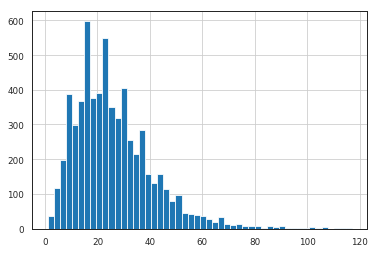

In [24]:
x.groupby('sent').size().hist(bins=50)

In [26]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [27]:
len(tag2idx)

38

In [29]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

In [28]:
X_real_test = [[word2idx[w[0]] for w in s] for s in real_test_sents]
X_real_dev = [[word2idx[w[0]] for w in s] for s in real_dev_sents]


In [29]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [30]:
X_real_dev = pad_sequences(maxlen=max_len, sequences=X_real_dev, value=word2idx["PAD"], padding='post', truncating='post')
X_real_test = pad_sequences(maxlen=max_len, sequences=X_real_test, value=word2idx["PAD"], padding='post', truncating='post')

In [31]:
X[1]

array([15077,  2258,  9171, 17533, 13243,  1785, 13243,  8413,  9171,
        8705, 10067,  4707,  2854,  7287, 13243, 13502, 14472, 13243,
       13739,  9171,  2051,  5103,  9171,  5481,  1982,  5923, 11283,
        4524,  9171, 12606, 12398, 14504,  3413,  1913, 15649,  3131,
       13243, 11445, 18250, 15957, 14555,  2357,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [32]:
X_real_dev[1]

array([14183, 14990,  4104,  1127,  3413,  7178, 13243, 13502, 14472,
       13243, 13739,  9807, 13243, 12943,  9171, 12606,  8888,  3413,
        7875, 16853, 16223, 17325,  2357,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [33]:
X_real_test[1]

array([13243, 12063, 14370, 11164,  3131, 10940, 13243, 14020,  3413,
       13243, 14070, 13243, 14401,  9171,  3131,  2865, 13243,  6614,
       13243,  4785, 12606,  7348,  3413, 13243, 10103,  9171, 13243,
       11420,  2374,  7440,  9171, 14472,  2943,  3413, 13243,  7781,
       14472,  8427,  7323,  2357,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [34]:
pos = list(set(x["pos"].values)|set(dev_df.new_pos.values)|set(test_df.new_pos.values))
n_pos = len(pos); n_pos

16

In [35]:
pos

['ADV',
 'ADJ',
 'X',
 'DET',
 'NOUN',
 'INTJ',
 'VERB',
 'PART',
 'CCONJ',
 'NUM',
 'PUNCT',
 'PROPN',
 'PRON',
 'SCONJ',
 'ADP',
 'AUX']

In [36]:
test_df.new_pos.unique()

array(['ADJ', 'ADP', 'DET', 'NOUN', 'VERB', 'PUNCT', 'PART', 'PRON',
       'SCONJ', 'PROPN', 'ADV', 'CCONJ', 'NUM'], dtype=object)

In [37]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([10,  5,  7, 15, 12, 15, 12, 14, 13,  7, 15,  5, 11,  9,  1,  7,  5,
        2,  2, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [69]:
X_real_test_pos = [[pos2idx[w[1]] for w in s] for s in real_test_sents]
X_real_test_pos = pad_sequences(maxlen=max_len, sequences=X_real_test_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_real_test_pos[0]

array([ 2, 15,  4,  5,  4,  2,  7,  7, 15,  5,  7,  5,  5, 15,  5, 11,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [70]:
X_real_dev_pos = [[pos2idx[w[1]] for w in s] for s in real_dev_sents]
X_real_dev_pos = pad_sequences(maxlen=max_len, sequences=X_real_dev_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_real_dev_pos[0]

array([10,  5,  7, 15, 12, 12, 14, 13,  7, 15,  4,  5, 11,  9,  1,  7,  5,
        2,  2, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

## True tags

In [30]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [31]:
y_numer[1]

array([34,  6,  5,  5, 23, 20, 20, 29,  5,  5,  5,  5,  5,  5, 23, 20, 20,
       20, 29,  5, 34,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [32]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
y[0].shape

(80, 38)

## Perform train test splits

In [42]:
train_sents = list(sents.reset_index()[sents.index.str.startswith('train')].index)
dev_sents = list(sents.reset_index()[sents.index.str.startswith('dev')].index)
test_sents = list(sents.reset_index()[sents.index.str.startswith('test')].index)
len(train_sents), len(dev_sents), len(test_sents)

(5241, 484, 491)

In [43]:
X_tr, pos_tr, y_tr = X[train_sents], X_pos[train_sents], [y[i] for i in train_sents]
X_te, pos_te, y_te = X[test_sents], X_pos[test_sents], [y[i] for i in test_sents]
X_dev, pos_dev, y_dev = X[dev_sents], X_pos[dev_sents], [y[i] for i in dev_sents]

In [44]:
validation_split = len(X_dev) / (len(X_tr)+len(X_dev))
validation_split

0.0845414847161572

In [51]:
splits = [[X_tr, X_dev,
           y_tr, y_dev,
           pos_tr, pos_dev ]]

### Prep char input

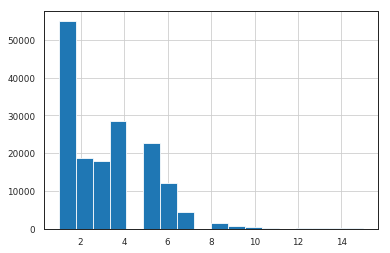

In [52]:
x.token.apply(len).hist(bins=18)

In [53]:
max_len_char = 10

In [56]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

49


In [57]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [58]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [59]:
X_char_tr = [X_char[i] for i in train_sents]
X_char_te = [X_char[i] for i in test_sents]
X_char_dev = [X_char[i] for i in dev_sents]
splits_char = [[X_char_tr, X_char_dev,
                y_tr, y_dev]]

In [60]:
X_real_test_char = []
for sentence in real_test_sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_real_test_char.append(np.array(sent_seq))

In [61]:
X_real_dev_char = []
for sentence in real_dev_sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_real_dev_char.append(np.array(sent_seq))

## Embeddings

In [62]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [63]:
exclude = ['cbow']

In [64]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1452
sample words not found:  ['ס.' 'וידאן' 'גקיל' 'תאוזכר' 'גימראש' 'שטוטגארט' 'הנצו' 'סי.' 'תשפרנה'
 'סונוורו']
loading word embeddings: ../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1452
sample words not found:  ['ונקאטרמאן' 'גפרי' 'זאלצבורג' 'שוודים' 'אוברקוביץ' 'השתדלנו' 'נאורלוג'
 'קונבקטורים' '22051' '0991']
loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1452
sample words not found:  ['תאצר' '0291' 'השחילו' 'מנצסטר' 'ריצארדס' 'דאקוורת' 'הייתכן' 'גורנאל'
 'ולסטון' '5203']
loading word embeddings: ../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt
found 

## Model building

In [65]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_

In [73]:
out_folder = 'outputs5'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [80]:
extra_preds = [(X_real_dev, X_real_dev_pos, X_real_dev_char), 
               (X_real_test, X_real_test_pos, X_real_test_char),
               (X_te, pos_te, X_char_te)]

In [81]:
from ner_utils import *

Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 56s - loss: 0.3290 - crf_accuracy: 0.9332 - val_loss: 0.1111 - val_crf_accuracy: 0.9840
Epoch 2/100
 - 55s - loss: 0.1377 - crf_accuracy: 0.9691 - val_loss: 0.0748 - val_crf_accuracy: 0.9849
Epoch 3/100
 - 60s - loss: 0.0937 - crf_accuracy: 0.9747 - val_loss: 0.0601 - val_crf_accuracy: 0.9866
Epoch 4/100
 - 61s - loss: 0.0642 - crf_accuracy: 0.9808 - val_loss: 0.0499 - val_crf_accuracy: 0.9875
Epoch 5/100
 - 60s - loss: 0.0445 - crf_accuracy: 0.9853 - val_loss: 0.0405 - val_crf_accuracy: 0.9896
Epoch 6/100
 - 63s - loss: 0.0311 - crf_accuracy: 0.9882 - val_loss: 0.0364 - val_crf_accuracy: 0.9884
Epoch 7/100
 - 60s - loss: 0.0216 - crf_accuracy: 0.9899 - val_loss: 0.0340 - val_crf_accuracy: 0.9870
Epoch 8/100
 - 58s - loss: 0.0134 - crf_accuracy: 0.9912 - val_loss: 0.0298 - val_crf_accuracy: 0.9882
Epoch 9/100
 - 63s - loss: 0.0069 - crf_accuracy: 0.9928 - val_loss: 0.0300 - val_crf_accuracy: 0.9863
Epoch 10/100
 - 56s - loss

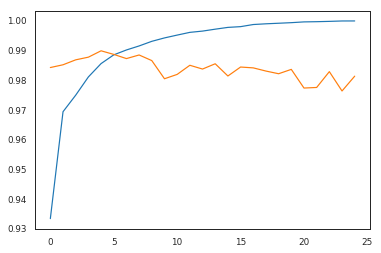

processed 11374 tokens with 488 phrases; found: 308 phrases; correct: 173.
accuracy:  33.27%; (non-O)
accuracy:  93.78%; precision:  56.17%; recall:  35.45%; FB1:  43.47
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  73.26%; recall:  52.50%; FB1:  61.17  86
              LOC: precision:  28.57%; recall:   7.69%; FB1:  12.12  7
              ORG: precision:  35.71%; recall:  30.43%; FB1:  32.86  98
              PER: precision:  62.39%; recall:  38.42%; FB1:  47.56  117
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 67s - loss: 0.3380 - crf_accuracy: 0.9342 - val_loss: 0.0947 - val_crf_accuracy: 0.9842
Epoch 2/100
 - 59s - loss: 0.1110 - c

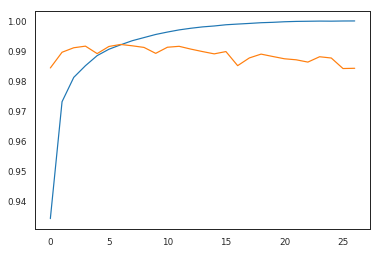

processed 11374 tokens with 488 phrases; found: 467 phrases; correct: 302.
accuracy:  56.32%; (non-O)
accuracy:  95.59%; precision:  64.67%; recall:  61.89%; FB1:  63.25
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  87.23%; recall:  68.33%; FB1:  76.64  94
              LOC: precision:  38.89%; recall:  26.92%; FB1:  31.82  18
              ORG: precision:  35.29%; recall:  57.39%; FB1:  43.71  187
              PER: precision:  88.55%; recall:  77.37%; FB1:  82.58  166
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 67s - loss: 0.2980 - crf_accuracy: 0.9428 - val_loss: 0.0755 - val_crf_accuracy: 0.9849
Epoch 2/100
 - 58s - loss: 0.0927 -

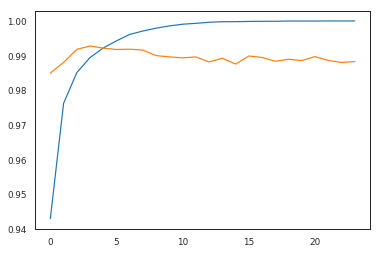

processed 11374 tokens with 488 phrases; found: 409 phrases; correct: 278.
accuracy:  54.80%; (non-O)
accuracy:  95.44%; precision:  67.97%; recall:  56.97%; FB1:  61.98
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  84.91%; recall:  75.00%; FB1:  79.65  106
              LOC: precision:  24.00%; recall:  23.08%; FB1:  23.53  25
              ORG: precision:  50.52%; recall:  42.61%; FB1:  46.23  97
              PER: precision:  73.89%; recall:  70.00%; FB1:  71.89  180
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 68s - loss: 0.2547 - crf_accuracy: 0.9487 - val_loss: 0.0572 - val_crf_accuracy: 0.9875
Epoch 2/100
 - 59s - loss: 0.0689 -

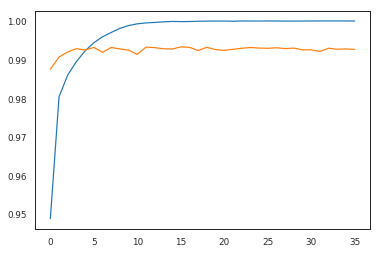

processed 11374 tokens with 488 phrases; found: 450 phrases; correct: 336.
accuracy:  63.60%; (non-O)
accuracy:  96.03%; precision:  74.67%; recall:  68.85%; FB1:  71.64
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:  50.00%; recall:  16.67%; FB1:  25.00  4
              GPE: precision:  84.62%; recall:  82.50%; FB1:  83.54  117
              LOC: precision:  61.54%; recall:  61.54%; FB1:  61.54  26
              ORG: precision:  59.43%; recall:  54.78%; FB1:  57.01  106
              PER: precision:  81.38%; recall:  80.53%; FB1:  80.95  188
              WOA: precision:  20.00%; recall:  12.50%; FB1:  15.38  5
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 66s - loss: 0.2657 - crf_accuracy: 0.9495 - val_loss: 0.0598 - val_crf_accuracy: 0.9880
Epoch 2/100
 - 60s - loss: 0.0720 

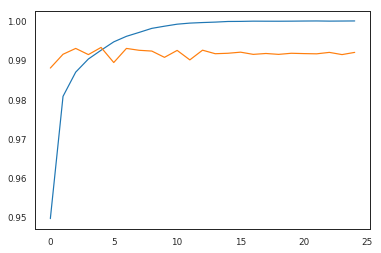

processed 11374 tokens with 488 phrases; found: 443 phrases; correct: 327.
accuracy:  61.48%; (non-O)
accuracy:  96.32%; precision:  73.81%; recall:  67.01%; FB1:  70.25
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  89.19%; recall:  82.50%; FB1:  85.71  111
              LOC: precision:  50.00%; recall:  38.46%; FB1:  43.48  20
              ORG: precision:  57.28%; recall:  51.30%; FB1:  54.13  103
              PER: precision:  76.44%; recall:  83.68%; FB1:  79.90  208
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 66s - loss: 0.2891 - crf_accuracy: 0.9487 - val_loss: 0.0769 - val_crf_accuracy: 0.9849
Epoch 2/100
 - 59s - loss: 0.0937 

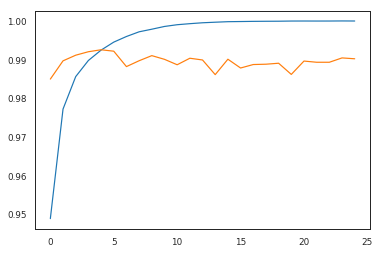

processed 11374 tokens with 488 phrases; found: 399 phrases; correct: 292.
accuracy:  58.24%; (non-O)
accuracy:  95.75%; precision:  73.18%; recall:  59.84%; FB1:  65.84
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  89.47%; recall:  70.83%; FB1:  79.07  95
              LOC: precision:  72.22%; recall:  50.00%; FB1:  59.09  18
              ORG: precision:  53.39%; recall:  54.78%; FB1:  54.08  118
              PER: precision:  78.92%; recall:  68.95%; FB1:  73.60  166
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 68s - loss: 0.2357 - crf_accuracy: 0.9560 - val_loss: 0.0696 - val_crf_accuracy: 0.9879
Epoch 2/100
 - 61s - loss: 0.0752 -

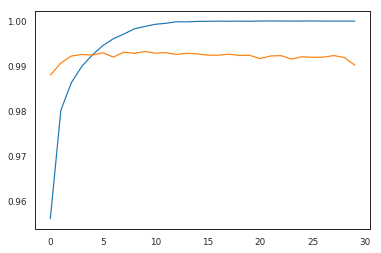

processed 11374 tokens with 488 phrases; found: 470 phrases; correct: 328.
accuracy:  63.50%; (non-O)
accuracy:  95.82%; precision:  69.79%; recall:  67.21%; FB1:  68.48
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              GPE: precision:  86.67%; recall:  75.83%; FB1:  80.89  105
              LOC: precision:  55.56%; recall:  57.69%; FB1:  56.60  27
              ORG: precision:  53.45%; recall:  53.91%; FB1:  53.68  116
              PER: precision:  75.48%; recall:  82.63%; FB1:  78.89  208
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 71s - loss: 0.2464 - crf_accuracy: 0.9597 - val_loss: 0.0619 - val_crf_accuracy: 0.9892
Epoch 2/100
 - 61s - loss: 0.0735 

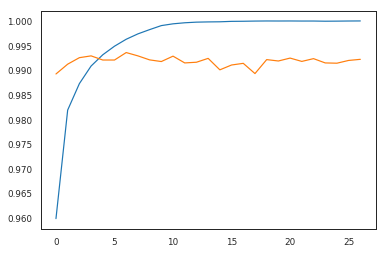

processed 11374 tokens with 488 phrases; found: 434 phrases; correct: 333.
accuracy:  62.59%; (non-O)
accuracy:  96.32%; precision:  76.73%; recall:  68.24%; FB1:  72.23
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  89.72%; recall:  80.00%; FB1:  84.58  107
              LOC: precision:  57.14%; recall:  61.54%; FB1:  59.26  28
              ORG: precision:  67.82%; recall:  51.30%; FB1:  58.42  87
              PER: precision:  78.71%; recall:  83.68%; FB1:  81.12  202
              WOA: precision:  25.00%; recall:  25.00%; FB1:  25.00  8
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 67s - loss: 0.2669 - crf_accuracy: 0.9486 - val_loss: 0.0719 - val_crf_accuracy: 0.9860
Epoch 2/100
 - 57s - loss: 0.0743 -

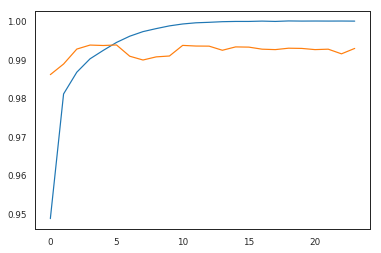

processed 11374 tokens with 488 phrases; found: 443 phrases; correct: 327.
accuracy:  62.49%; (non-O)
accuracy:  96.36%; precision:  73.81%; recall:  67.01%; FB1:  70.25
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  91.51%; recall:  80.83%; FB1:  85.84  106
              LOC: precision:  17.14%; recall:  23.08%; FB1:  19.67  35
              ORG: precision:  60.00%; recall:  57.39%; FB1:  58.67  110
              PER: precision:  82.72%; recall:  83.16%; FB1:  82.94  191
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 66s - loss: 0.2884 - crf_accuracy: 0.9433 - val_loss: 0.0667 - val_crf_accuracy: 0.9856
Epoch 2/100
 - 56s - loss: 0.0829 

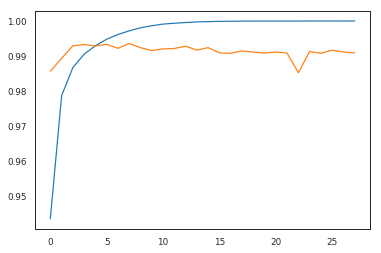

processed 11374 tokens with 488 phrases; found: 410 phrases; correct: 333.
accuracy:  60.67%; (non-O)
accuracy:  96.36%; precision:  81.22%; recall:  68.24%; FB1:  74.16
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:  14.29%; recall:   8.33%; FB1:  10.53  7
              GPE: precision:  91.59%; recall:  81.67%; FB1:  86.34  107
              LOC: precision:  73.33%; recall:  42.31%; FB1:  53.66  15
              ORG: precision:  64.37%; recall:  48.70%; FB1:  55.45  87
              PER: precision:  87.43%; recall:  87.89%; FB1:  87.66  191
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 71s - loss: 0.2492 - crf_accuracy: 0.9562 - val_loss: 0.0612 - val_crf_accuracy: 0.9891
Epoch 2/100
 - 56s - loss: 0.0720 -

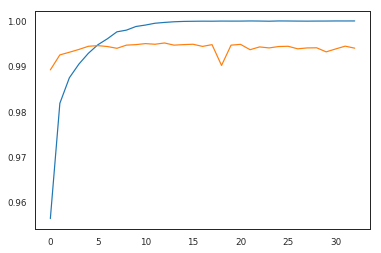

processed 11374 tokens with 488 phrases; found: 474 phrases; correct: 377.
accuracy:  70.17%; (non-O)
accuracy:  96.89%; precision:  79.54%; recall:  77.25%; FB1:  78.38
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  33.33%; recall:   8.33%; FB1:  13.33  3
              FAC: precision:  12.50%; recall:   8.33%; FB1:  10.00  8
              GPE: precision:  91.96%; recall:  85.83%; FB1:  88.79  112
              LOC: precision:  66.67%; recall:  69.23%; FB1:  67.92  27
              ORG: precision:  62.90%; recall:  67.83%; FB1:  65.27  124
              PER: precision:  90.10%; recall:  91.05%; FB1:  90.58  192
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 71s - loss: 0.2818 - crf_accuracy: 0.9448 - val_loss: 0.0572 - val_crf_accuracy: 0.9893
Epoch 2/100
 - 57s - loss: 0.0706 

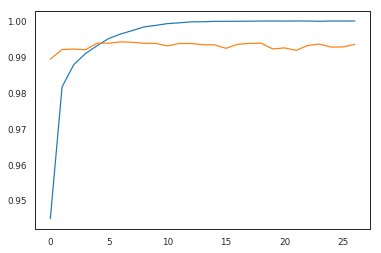

processed 11374 tokens with 488 phrases; found: 437 phrases; correct: 347.
accuracy:  63.20%; (non-O)
accuracy:  96.62%; precision:  79.41%; recall:  71.11%; FB1:  75.03
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  83.46%; recall:  88.33%; FB1:  85.83  127
              LOC: precision:  58.33%; recall:  53.85%; FB1:  56.00  24
              ORG: precision:  59.65%; recall:  59.13%; FB1:  59.39  114
              PER: precision:  95.12%; recall:  82.11%; FB1:  88.14  164
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 73s - loss: 0.2915 - crf_accuracy: 0.9383 - val_loss: 0.0635 - val_crf_accuracy: 0.9856
Epoch 2/100
 - 62s - loss: 0.0776 

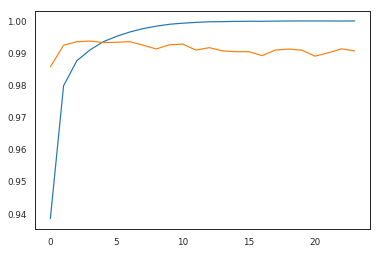

processed 11374 tokens with 488 phrases; found: 443 phrases; correct: 338.
accuracy:  62.49%; (non-O)
accuracy:  96.54%; precision:  76.30%; recall:  69.26%; FB1:  72.61
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  90.83%; recall:  82.50%; FB1:  86.46  109
              LOC: precision:  76.47%; recall:  50.00%; FB1:  60.47  17
              ORG: precision:  49.22%; recall:  54.78%; FB1:  51.85  128
              PER: precision:  86.70%; recall:  85.79%; FB1:  86.24  188
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 71s - loss: 0.2476 - crf_accuracy: 0.9513 - val_loss: 0.0551 - val_crf_accuracy: 0.9889
Epoch 2/100
 - 62s - loss: 0.0655 

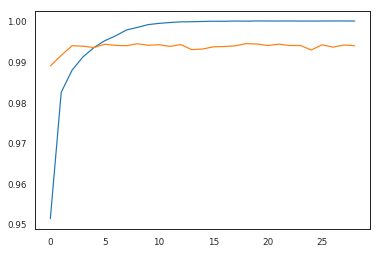

processed 11374 tokens with 488 phrases; found: 445 phrases; correct: 348.
accuracy:  64.71%; (non-O)
accuracy:  96.56%; precision:  78.20%; recall:  71.31%; FB1:  74.60
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
              GPE: precision:  90.91%; recall:  83.33%; FB1:  86.96  110
              LOC: precision:  66.67%; recall:  53.85%; FB1:  59.57  21
              ORG: precision:  55.75%; recall:  54.78%; FB1:  55.26  113
              PER: precision:  87.89%; recall:  87.89%; FB1:  87.89  190
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 78s - loss: 0.2386 - crf_accuracy: 0.9543 - val_loss: 0.0550 - val_crf_accuracy: 0.9886
Epoch 2/100
 - 57s - loss: 0.0648 

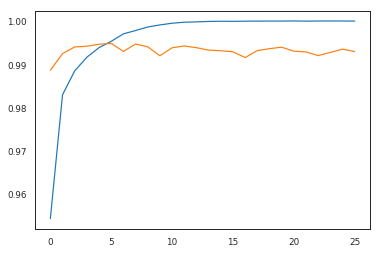

processed 11374 tokens with 488 phrases; found: 445 phrases; correct: 362.
accuracy:  65.02%; (non-O)
accuracy:  96.83%; precision:  81.35%; recall:  74.18%; FB1:  77.60
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  90.35%; recall:  85.83%; FB1:  88.03  114
              LOC: precision:  54.17%; recall:  50.00%; FB1:  52.00  24
              ORG: precision:  73.03%; recall:  56.52%; FB1:  63.73  89
              PER: precision:  83.72%; recall:  94.74%; FB1:  88.89  215
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 73s - loss: 0.2477 - crf_accuracy: 0.9617 - val_loss: 0.0584 - val_crf_accuracy: 0.9899
Epoch 2/100
 - 60s - loss: 0.0698 -

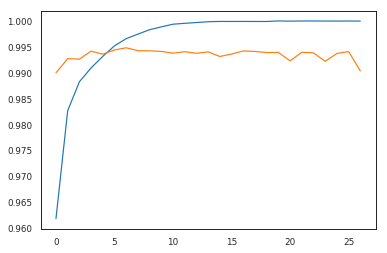

processed 11374 tokens with 488 phrases; found: 445 phrases; correct: 362.
accuracy:  65.12%; (non-O)
accuracy:  96.70%; precision:  81.35%; recall:  74.18%; FB1:  77.60
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  89.47%; recall:  85.00%; FB1:  87.18  114
              LOC: precision:  63.64%; recall:  53.85%; FB1:  58.33  22
              ORG: precision:  66.34%; recall:  58.26%; FB1:  62.04  101
              PER: precision:  88.00%; recall:  92.63%; FB1:  90.26  200
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 86s - loss: 0.3384 - crf_accuracy: 0.9342 - val_loss: 0.1196 - val_crf_accuracy: 0.9841
Epoch 2/100
 - 70s - loss: 0.1424 

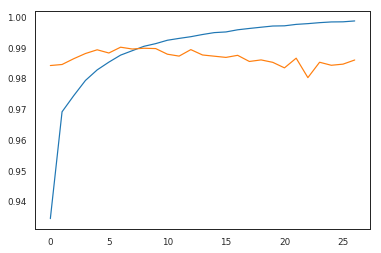

processed 11374 tokens with 488 phrases; found: 293 phrases; correct: 208.
accuracy:  36.60%; (non-O)
accuracy:  94.26%; precision:  70.99%; recall:  42.62%; FB1:  53.27
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  71.05%; recall:  67.50%; FB1:  69.23  114
              LOC: precision:  42.86%; recall:  11.54%; FB1:  18.18  7
              ORG: precision:  59.62%; recall:  26.96%; FB1:  37.13  52
              PER: precision:  77.50%; recall:  48.95%; FB1:  60.00  120
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 83s - loss: 0.3566 - crf_accuracy: 0.9236 - val_loss: 0.0870 - val_crf_accuracy: 0.9841
Epoch 2/100
 - 71s - loss: 0.1083 - 

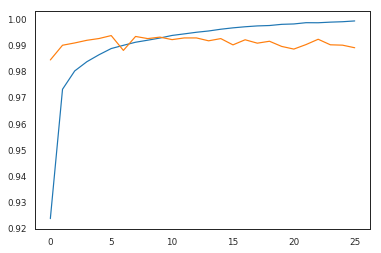

processed 11374 tokens with 488 phrases; found: 442 phrases; correct: 311.
accuracy:  55.51%; (non-O)
accuracy:  95.94%; precision:  70.36%; recall:  63.73%; FB1:  66.88
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  85.87%; recall:  65.83%; FB1:  74.53  92
              LOC: precision:  40.74%; recall:  42.31%; FB1:  41.51  27
              ORG: precision:  52.22%; recall:  40.87%; FB1:  45.85  90
              PER: precision:  74.68%; recall:  91.58%; FB1:  82.27  233
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 87s - loss: 0.2951 - crf_accuracy: 0.9435 - val_loss: 0.0877 - val_crf_accuracy: 0.9845
Epoch 2/100
 - 70s - loss: 0.0897 - 

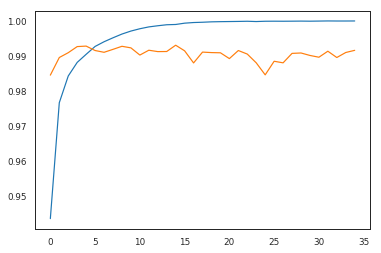

processed 11374 tokens with 488 phrases; found: 412 phrases; correct: 304.
accuracy:  58.34%; (non-O)
accuracy:  95.56%; precision:  73.79%; recall:  62.30%; FB1:  67.56
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              EVE: precision:  50.00%; recall:   8.33%; FB1:  14.29  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  90.00%; recall:  75.00%; FB1:  81.82  100
              LOC: precision:  46.67%; recall:  53.85%; FB1:  50.00  30
              ORG: precision:  62.77%; recall:  51.30%; FB1:  56.46  94
              PER: precision:  80.46%; recall:  73.68%; FB1:  76.92  174
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 91s - loss: 0.2646 - crf_accuracy: 0.9465 - val_loss: 0.0600 - val_crf_accuracy: 0.9873
Epoch 2/100
 - 69s - loss: 0.0805 -

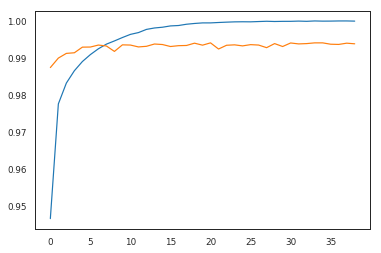

processed 11374 tokens with 488 phrases; found: 440 phrases; correct: 341.
accuracy:  64.81%; (non-O)
accuracy:  96.32%; precision:  77.50%; recall:  69.88%; FB1:  73.49
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  66.67%; recall:  16.67%; FB1:  26.67  3
              FAC: precision:  14.29%; recall:   8.33%; FB1:  10.53  7
              GPE: precision:  86.36%; recall:  79.17%; FB1:  82.61  110
              LOC: precision:  51.72%; recall:  57.69%; FB1:  54.55  29
              ORG: precision:  65.35%; recall:  57.39%; FB1:  61.11  101
              PER: precision:  86.34%; recall:  83.16%; FB1:  84.72  183
              WOA: precision:  25.00%; recall:  12.50%; FB1:  16.67  4
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 94s - loss: 0.2696 - crf_accuracy: 0.9497 - val_loss: 0.0750 - val_crf_accuracy: 0.9880
Epoch 2/100
 - 70s - loss: 0.0816 

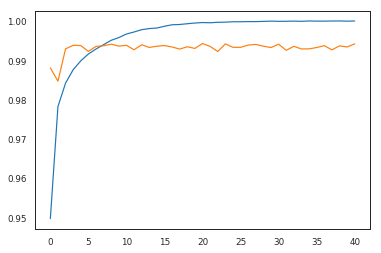

processed 11374 tokens with 488 phrases; found: 401 phrases; correct: 333.
accuracy:  62.49%; (non-O)
accuracy:  96.31%; precision:  83.04%; recall:  68.24%; FB1:  74.92
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:  16.67%; FB1:  28.57  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
              GPE: precision:  94.95%; recall:  78.33%; FB1:  85.84  99
              LOC: precision:  52.94%; recall:  69.23%; FB1:  60.00  34
              ORG: precision:  78.38%; recall:  50.43%; FB1:  61.38  74
              PER: precision:  91.72%; recall:  81.58%; FB1:  86.35  169
              WOA: precision:  25.00%; recall:  37.50%; FB1:  30.00  12
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 93s - loss: 0.2828 - crf_accuracy: 0.9459 - val_loss: 0.0791 - val_crf_accuracy: 0.9844
Epoch 2/100
 - 68s - loss: 0.0877 -

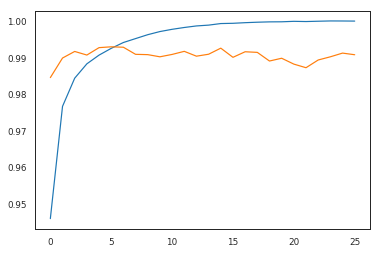

processed 11374 tokens with 488 phrases; found: 386 phrases; correct: 295.
accuracy:  55.81%; (non-O)
accuracy:  95.79%; precision:  76.42%; recall:  60.45%; FB1:  67.51
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  86.73%; recall:  70.83%; FB1:  77.98  98
              LOC: precision:  60.00%; recall:  46.15%; FB1:  52.17  20
              ORG: precision:  61.80%; recall:  47.83%; FB1:  53.92  89
              PER: precision:  79.89%; recall:  75.26%; FB1:  77.51  179
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 94s - loss: 0.2374 - crf_accuracy: 0.9537 - val_loss: 0.0653 - val_crf_accuracy: 0.9881
Epoch 2/100
 - 70s - loss: 0.0826 - 

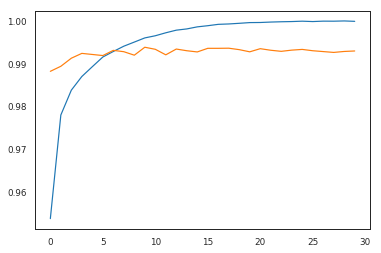

processed 11374 tokens with 488 phrases; found: 446 phrases; correct: 345.
accuracy:  64.21%; (non-O)
accuracy:  96.35%; precision:  77.35%; recall:  70.70%; FB1:  73.88
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:  16.67%; FB1:  28.57  2
              FAC: precision:  33.33%; recall:   8.33%; FB1:  13.33  3
              GPE: precision:  86.07%; recall:  87.50%; FB1:  86.78  122
              LOC: precision:  65.00%; recall:  50.00%; FB1:  56.52  20
              ORG: precision:  65.12%; recall:  48.70%; FB1:  55.72  86
              PER: precision:  80.49%; recall:  86.84%; FB1:  83.54  205
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 98s - loss: 0.2472 - crf_accuracy: 0.9596 - val_loss: 0.0634 - val_crf_accuracy: 0.9887
Epoch 2/100
 - 68s - loss: 0.0822 -

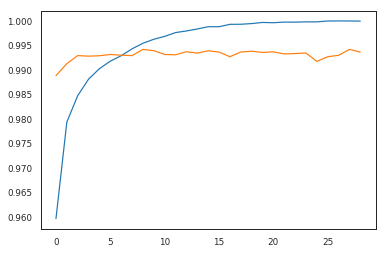

processed 11374 tokens with 488 phrases; found: 414 phrases; correct: 343.
accuracy:  64.51%; (non-O)
accuracy:  96.50%; precision:  82.85%; recall:  70.29%; FB1:  76.05
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
              GPE: precision:  93.46%; recall:  83.33%; FB1:  88.11  107
              LOC: precision:  71.43%; recall:  57.69%; FB1:  63.83  21
              ORG: precision:  68.42%; recall:  56.52%; FB1:  61.90  95
              PER: precision:  90.45%; recall:  84.74%; FB1:  87.50  178
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  6
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 95s - loss: 0.2718 - crf_accuracy: 0.9411 - val_loss: 0.0616 - val_crf_accuracy: 0.9876
Epoch 2/100
 - 63s - loss: 0.0792 -

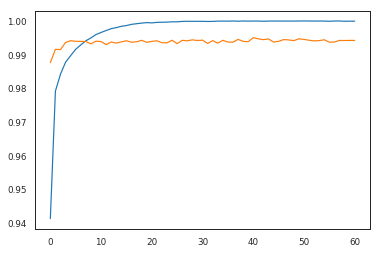

processed 11374 tokens with 488 phrases; found: 428 phrases; correct: 352.
accuracy:  65.02%; (non-O)
accuracy:  96.45%; precision:  82.24%; recall:  72.13%; FB1:  76.86
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  91.74%; recall:  83.33%; FB1:  87.34  109
              LOC: precision:  50.00%; recall:  65.38%; FB1:  56.67  34
              ORG: precision:  70.33%; recall:  55.65%; FB1:  62.14  91
              PER: precision:  92.18%; recall:  86.84%; FB1:  89.43  179
              WOA: precision:  22.22%; recall:  25.00%; FB1:  23.53  9
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 96s - loss: 0.3096 - crf_accuracy: 0.9378 - val_loss: 0.0672 - val_crf_accuracy: 0.9860
Epoch 2/100
 - 70s - loss: 0.0868 -

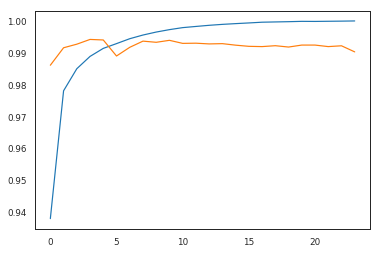

processed 11374 tokens with 488 phrases; found: 436 phrases; correct: 323.
accuracy:  57.23%; (non-O)
accuracy:  96.18%; precision:  74.08%; recall:  66.19%; FB1:  69.91
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  84.55%; recall:  77.50%; FB1:  80.87  110
              LOC: precision:  39.13%; recall:  34.62%; FB1:  36.73  23
              ORG: precision:  46.32%; recall:  38.26%; FB1:  41.90  95
              PER: precision:  85.10%; recall:  93.16%; FB1:  88.94  208
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 100s - loss: 0.2481 - crf_accuracy: 0.9533 - val_loss: 0.0621 - val_crf_accuracy: 0.9889
Epoch 2/100
 - 64s - loss: 0.0760 

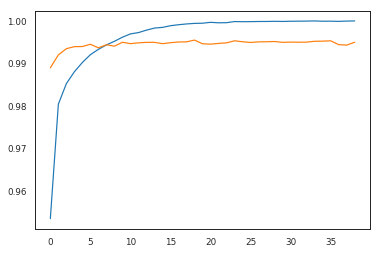

processed 11374 tokens with 488 phrases; found: 464 phrases; correct: 374.
accuracy:  68.76%; (non-O)
accuracy:  96.72%; precision:  80.60%; recall:  76.64%; FB1:  78.57
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  50.00%; recall:  16.67%; FB1:  25.00  4
              FAC: precision:  20.00%; recall:   8.33%; FB1:  11.76  5
              GPE: precision:  88.33%; recall:  88.33%; FB1:  88.33  120
              LOC: precision:  56.00%; recall:  53.85%; FB1:  54.90  25
              ORG: precision:  67.92%; recall:  62.61%; FB1:  65.16  106
              PER: precision:  91.19%; recall:  92.63%; FB1:  91.91  193
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 107s - loss: 0.2703 - crf_accuracy: 0.9466 - val_loss: 0.0590 - val_crf_accuracy: 0.9896
Epoch 2/100
 - 68s - loss: 0.0739

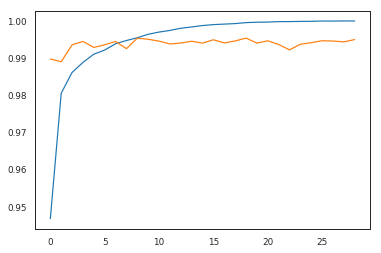

processed 11374 tokens with 488 phrases; found: 445 phrases; correct: 370.
accuracy:  67.04%; (non-O)
accuracy:  96.89%; precision:  83.15%; recall:  75.82%; FB1:  79.31
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:  33.33%; recall:   8.33%; FB1:  13.33  3
              GPE: precision:  90.68%; recall:  89.17%; FB1:  89.92  118
              LOC: precision:  63.64%; recall:  53.85%; FB1:  58.33  22
              ORG: precision:  68.87%; recall:  63.48%; FB1:  66.06  106
              PER: precision:  90.00%; recall:  90.00%; FB1:  90.00  190
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 106s - loss: 0.2941 - crf_accuracy: 0.9413 - val_loss: 0.0663 - val_crf_accuracy: 0.9860
Epoch 2/100
 - 69s - loss: 0.0827

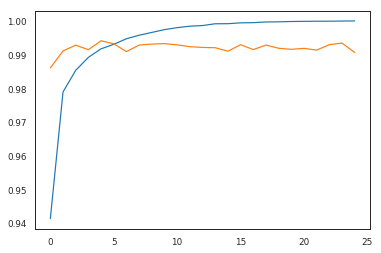

processed 11374 tokens with 488 phrases; found: 458 phrases; correct: 354.
accuracy:  62.99%; (non-O)
accuracy:  96.56%; precision:  77.29%; recall:  72.54%; FB1:  74.84
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  85.83%; recall:  90.83%; FB1:  88.26  127
              LOC: precision:  30.43%; recall:  26.92%; FB1:  28.57  23
              ORG: precision:  61.86%; recall:  52.17%; FB1:  56.60  97
              PER: precision:  85.58%; recall:  93.68%; FB1:  89.45  208
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 105s - loss: 0.2264 - crf_accuracy: 0.9531 - val_loss: 0.0528 - val_crf_accuracy: 0.9888
Epoch 2/100
 - 63s - loss: 0.0669 

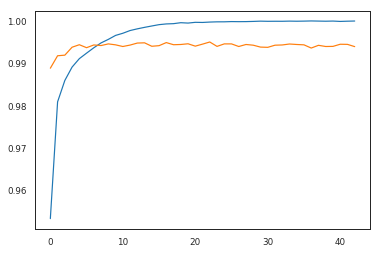

processed 11374 tokens with 488 phrases; found: 459 phrases; correct: 372.
accuracy:  66.43%; (non-O)
accuracy:  96.75%; precision:  81.05%; recall:  76.23%; FB1:  78.56
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  87.50%; recall:  87.50%; FB1:  87.50  120
              LOC: precision:  61.90%; recall:  50.00%; FB1:  55.32  21
              ORG: precision:  73.27%; recall:  64.35%; FB1:  68.52  101
              PER: precision:  86.70%; recall:  92.63%; FB1:  89.57  203
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  7
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 111s - loss: 0.2495 - crf_accuracy: 0.9482 - val_loss: 0.0555 - val_crf_accuracy: 0.9886
Epoch 2/100
 - 71s - loss: 0.0739

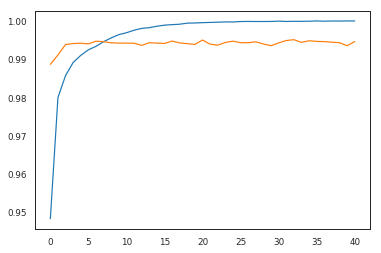

processed 11374 tokens with 488 phrases; found: 453 phrases; correct: 374.
accuracy:  68.76%; (non-O)
accuracy:  96.71%; precision:  82.56%; recall:  76.64%; FB1:  79.49
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  66.67%; recall:  16.67%; FB1:  26.67  3
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  92.92%; recall:  87.50%; FB1:  90.13  113
              LOC: precision:  53.33%; recall:  61.54%; FB1:  57.14  30
              ORG: precision:  67.96%; recall:  60.87%; FB1:  64.22  103
              PER: precision:  89.90%; recall:  93.68%; FB1:  91.75  198
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4797 samples, validate on 444 samples
Epoch 1/100
 - 105s - loss: 0.2480 - crf_accuracy: 0.9425 - val_loss: 0.0566 - val_crf_accuracy: 0.9885
Epoch 2/100
 - 68s - loss: 0.0736

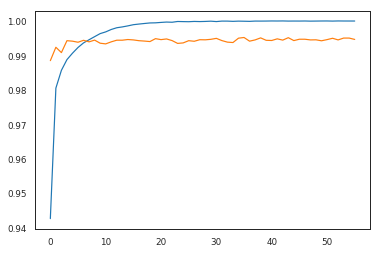

processed 11374 tokens with 488 phrases; found: 468 phrases; correct: 381.
accuracy:  69.67%; (non-O)
accuracy:  96.88%; precision:  81.41%; recall:  78.07%; FB1:  79.71
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  7
              GPE: precision:  91.07%; recall:  85.00%; FB1:  87.93  112
              LOC: precision:  60.71%; recall:  65.38%; FB1:  62.96  28
              ORG: precision:  67.77%; recall:  71.30%; FB1:  69.49  121
              PER: precision:  91.67%; recall:  92.63%; FB1:  92.15  192
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4


In [82]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_dev_only', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                )

In [83]:
results

[[(56.16883116883117, 35.450819672131146, 43.46733668341709)],
 [(64.66809421841542, 61.885245901639344, 63.24607329842933)],
 [(67.97066014669927, 56.9672131147541, 61.98439241917503)],
 [(74.66666666666667, 68.85245901639344, 71.64179104477613)],
 [(73.81489841986456, 67.00819672131148, 70.24704618689582)],
 [(73.1829573934837, 59.83606557377049, 65.83990980834274)],
 [(69.7872340425532, 67.21311475409836, 68.4759916492693)],
 [(76.72811059907833, 68.23770491803278, 72.23427331887201)],
 [(73.81489841986456, 67.00819672131148, 70.24704618689582)],
 [(81.21951219512195, 68.23770491803278, 74.16481069042317)],
 [(79.53586497890295, 77.25409836065575, 78.37837837837839)],
 [(79.40503432494279, 71.10655737704919, 75.02702702702703)],
 [(76.2979683972912, 69.26229508196722, 72.61009667024706)],
 [(78.20224719101122, 71.31147540983606, 74.59807073954985)],
 [(81.34831460674158, 74.18032786885246, 77.59914255091104)],
 [(81.34831460674158, 74.18032786885246, 77.59914255091104)],
 [(70.98976

## Predict on realistic test

In [ ]:
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss

path = 'outputs3/treebank_realistic-16-model.h5'

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "crf_loss": loss, "crf_accuracy":accuracy}

def load_keras_model(path):
    model = load_model(path, custom_objects=create_custom_objects())
    return model

model = load_keras_model(path)

In [ ]:
i=122
params = []
params.append(np.array([X_real[i]]))
#params.append(np.array([X_real_pos[i]]))
params.append(np.array([X_real_char[i]]))
p = model.predict(params)
p = np.argmax(p, axis=-1)

for w, pred in zip(X_real[i], p[0]):
    if idx2word[w]!="PAD":
        print("{:15}: {}".format(idx2word[w], idx2tag[pred]))

In [ ]:
i=124
params = []
params.append(np.array([X_te[i]]))
#params.append(np.array([pos_te[i]]))
params.append(np.array([X_char_te[i]]))
p = model.predict(params)
p = np.argmax(p, axis=-1)

for w, pred in zip(X_te[i], p[0]):
    if idx2word[w]!="PAD":
        print("{:15}: {}".format(idx2word[w], idx2tag[pred]))

In [46]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0001, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [48]:
for conf in configs:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]

In [ ]:
len(list(zip(configs, results, preds, histories)))

In [52]:
def get_results_df(configs, results):
    dict_res = []
    for conf, res in zip(configs, results):
        dr = {}
        for i, r in enumerate(res):
            split_name = chr(ord('a')+i)
            dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
        dr.update(conf)
        dict_res.append(dr)
    rdf = (pd.DataFrame(dict_res)
           .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
           .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
           .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))
    return rdf

In [53]:
res1 = pickle.load(open('treebank_results_1.pkl', 'rb'))

In [54]:
res2 = pickle.load(open('treebank_results_2_test25.pkl', 'rb'))

In [57]:
rdf1 = get_results_df([c for c, r, h in res1], [r for c, r, h in res1])

In [58]:
rdf2 = get_results_df([c for c, r, p, h in res2], [r for c, r, p, h in res2])

In [60]:
rdf2.head()

,crf,early_stopping,embed_dim,embedding_matrix,epochs,f1_a,f1_b,f1_c,input_dropout,min_delta,...,stack_double,stack_lstm,trainable,use_char,use_morpheme,use_pos,use_word,prec,recall,f1
0,True,True,70,None,100,61.595231,64.524986,63.937419,False,0.0001,...,False,1,True,False,True,False,False,66.866298,60.221498,63.352545
1,True,True,70,None,100,72.074967,71.615721,72.101911,False,0.0001,...,False,1,True,False,True,True,False,73.574440,70.383441,71.930866
2,True,True,300,fastext,100,77.924131,76.407437,77.421053,False,0.0001,...,False,1,True,False,True,False,False,78.371539,76.234033,77.250873
3,True,True,300,fastext,100,80.941052,79.862215,80.050761,False,0.0001,...,False,1,True,False,True,True,False,80.810288,79.768234,80.284676
4,True,True,70,None,100,69.732492,67.697498,70.299037,False,0.0001,...,False,1,True,True,True,False,False,74.882658,64.751970,69.243009


In [61]:
 (rdf2.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                63.4  71.9  69.2  75.0
fastext           77.3  80.3  82.0  83.3

In [63]:
 (rdf1.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                67.9  74.4  70.7  75.8
fastext           79.4  83.4  82.9  84.6